In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

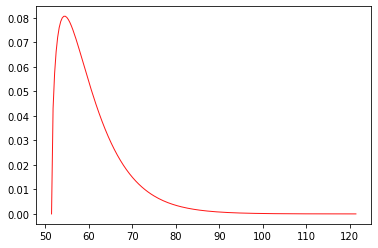

In [3]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(120-50), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [4]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/india/2020_02_24_01_05_37/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/pakistan/2020_02_24_01_08_41/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/mali/2020_02_24_01_07_25/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/tanzania/2020_02_24_01_10_34/count_data/']

locations = ['India','Pakistan','Mali','Tanzania']

#use in sort_values to make custum sort list. I sorted by region. 
sorter = ['India','Pakistan','Mali','Tanzania']
sorterIndex = dict(zip(sorter,range(len(sorter))))


In [5]:
master_avg = pd.DataFrame()
master_draws = pd.DataFrame()
master_counts = pd.DataFrame()

for i in list(range(len(output_dirs))):
    ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
    treatment = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_pt = dalys.merge(person_time, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    dalys_tot = dalys_pt.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    count = dalys_tot
    count['location'] = locations[i]
    master_counts = master_counts.append(count)

    # add cost data
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population'] / dalys_baseline['total_population'] * 100_000
    dalys_baseline['dalys'] = dalys_baseline['dalys'] / dalys_baseline['total_population'] * 100_000
  
    
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] / dalys_mmn['total_population'] * 100_000
    dalys_mmn['dalys'] = dalys_mmn['dalys'] / dalys_mmn['total_population'] * 100_000
    dalys_mmn = dalys_mmn.drop(columns='person_time')

    dalys_bep = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep['cost'] = dalys_bep['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep['person_time'])) / dalys_bep['total_population'] * 100_000
    dalys_bep['cost_bep_avg'] = 60.42 * dalys_bep['bep_population'] / dalys_bep['total_population'] * 100_000
    dalys_bep['cost_bep_low'] = 51.42 * dalys_bep['bep_population'] / dalys_bep['total_population'] * 100_000
    dalys_bep['cost_bep_high'] = 120.42 * dalys_bep['bep_population'] / dalys_bep['total_population'] * 100_000
    dalys_bep['dalys'] = dalys_bep['dalys'] / dalys_bep['total_population'] * 100_000
    dalys_bep = dalys_bep.drop(columns='person_time')
    
    dalys_bep_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep_targeted['cost'] = ((dalys_bep_targeted['bep_population'] * 
                                  scipy.stats.gamma.rvs(a, loc, scale, 
                                                        size=len(dalys_bep_targeted['person_time'])) 
                                  + dalys_bep_targeted['mmn_population'] * 3.69) 
                                  / dalys_bep_targeted['total_population'] * 100_000)
    dalys_bep_targeted['cost_bep_targeted_avg'] = ((60.42 * dalys_bep_targeted['bep_population'] + 
                                                   dalys_bep_targeted['mmn_population'] * 3.69)  
                                                    / dalys_bep_targeted['total_population'] * 100_000)
    dalys_bep_targeted['cost_bep_targeted_low'] = ((51.42 * dalys_bep_targeted['bep_population'] + 
                                                    dalys_bep_targeted['mmn_population'] * 3.69) 
                                                   / dalys_bep_targeted['total_population'] * 100_000) 
    dalys_bep_targeted['cost_bep_targeted_high'] = ((120.42 * dalys_bep_targeted['bep_population'] + 
                                                     dalys_bep_targeted['mmn_population'] * 3.69) 
                                                    / dalys_bep_targeted['total_population'] * 100_000)
    dalys_bep_targeted['dalys'] = dalys_bep_targeted['dalys'] / dalys_bep_targeted['total_population'] * 100_000
    dalys_bep_targeted = dalys_bep_targeted.drop(columns='person_time')
    
    
    dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_mmn'])
    dalys_scenarios2 = dalys_baseline.merge(dalys_bep, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep'])
    dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])
    
    
    
    dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    
    dalys_scenarios = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    
    
    dalys_scenarios = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])

    dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_avg'] = dalys_scenarios['cost_bep_avg'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_low'] = dalys_scenarios['cost_bep_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_high'] = dalys_scenarios['cost_bep_high'] - dalys_scenarios['cost_baseline']
    
    dalys_scenarios['dalys_averted_bep_targeted'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep_targeted'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_low'] = dalys_scenarios['cost_bep_targeted_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_high'] = dalys_scenarios['cost_bep_targeted_high'] - dalys_scenarios['cost_baseline']

    dalys_scenarios['cost_averted_bep_rel_to_mmn'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_rel_to_mmn'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_mmn']
    
    dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['dalys_bep']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_bep']

    dalys_scenarios['icer_mmn'] = dalys_scenarios['cost_averted_mmn'] / dalys_scenarios['dalys_averted_mmn']
    dalys_scenarios['icer_bep'] = dalys_scenarios['cost_averted_bep'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted'] = dalys_scenarios['cost_averted_bep_targeted'] / dalys_scenarios['dalys_averted_bep_targeted']
        
    dalys_scenarios['icer_bep_low'] = dalys_scenarios['cost_averted_bep_low'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_high'] = dalys_scenarios['cost_averted_bep_high'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted_low'] = dalys_scenarios['cost_averted_bep_targeted_low'] / dalys_scenarios['dalys_averted_bep_targeted']
    dalys_scenarios['icer_bep_targeted_high'] = dalys_scenarios['cost_averted_bep_targeted_high'] / dalys_scenarios['dalys_averted_bep_targeted']
    
    dalys_scenarios['icer_bep_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep']
    
    dalys_scenarios = dalys_scenarios.set_index(['input_draw'])
    
    dalys_scenarios['location'] = locations[i]
    master_draws = master_draws.append(dalys_scenarios.reset_index())
        
    dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw','person_time'])
    dalys_mean = pd.DataFrame(dalys_prep.mean())
    dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
    dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))
    
    per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)
    per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
    final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
    final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
    final_per_pt = final_per_pt.reset_index()
    final_per_pt['location'] = locations[i]
    master_avg = master_avg.append(final_per_pt)
    
# perform lexicographic sort on a dataframe  
master_avg['location_rank'] = master_avg['location'].map(sorterIndex)
master_avg = master_avg.sort_values(by='location_rank')
#master_avg.drop('location_rank', 1, inplace = True)
master_avg.head()
    

,index,mean,min,max,location,location_rank
0,dalys_baseline,2.871909e+05,2.675842e+05,3.031956e+05,India,0
33,cost_bep_targeted_high,1.862636e+06,1.734188e+06,2.015737e+06,India,0
34,dalys_averted_mmn,-4.101683e+03,-5.710909e+03,-2.459946e+03,India,0
35,cost_averted_mmn,2.015061e+05,1.901516e+05,2.090104e+05,India,0
36,dalys_averted_bep,-2.542996e+04,-3.002347e+04,-2.234262e+04,India,0


In [6]:
# number of treated individuals in each scenario/location per 100,000 births
treated_numbers = master_counts
treated_numbers['treated'] = (treated_numbers['bep_population']+treated_numbers['ifa_population']+treated_numbers['mmn_population'])/treated_numbers['total_population']*100_000
treated_counts = treated_numbers.groupby(['scenario','location']).mean().reset_index()
treated_counts = treated_counts[['scenario','location','treated']]
treated_counts

,scenario,location,treated
0,baseline,India,34031.68
1,baseline,Mali,23299.20
2,baseline,Pakistan,24718.94
3,baseline,Tanzania,20970.90
4,bep_scale_up,India,79417.70
5,bep_scale_up,Mali,75143.80
6,bep_scale_up,Pakistan,75941.50
7,bep_scale_up,Tanzania,88484.88
8,bep_targeted_scale_up,India,79417.70
9,bep_targeted_scale_up,Mali,75143.80


In [7]:
prep = master_avg.where(master_avg['index'] != 'icer_bep_targeted_rel_to_bep').dropna()

prep['val'] = prep['mean'].map(int).map(str) + ' (' + prep['min'].map(int).map(str) + ', ' + prep['max'].map(int).map(str) + ')'
prep['measure'] = np.where(prep['index'].str.contains('dalys_averted'), 'dalys', 'drop')
prep['measure'] = np.where(prep['index'].str.contains('cost'), 'cost', prep['measure'])
prep['measure'] = np.where(prep['index'].str.contains('icer'), 'icer', prep['measure'])
prep = prep.where(prep['measure'] != 'drop').dropna()
prep['scenario'] = np.where(prep['index'] == 'cost_baseline', 'baseline', 'na')
prep['scenario'] = np.where(prep['index'] == 'cost_mmn', 'mmn_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'cost_bep', 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'cost_bep_targeted', 'bep_targeted_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_baseline', 'baseline', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_mmn', 'mmn_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep', 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep_targeted', 'bep_targeted_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep_rel_to_mmn', 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep_targeted_rel_to_mmn', 'bep_targeted_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_baseline'), 'baseline', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_mmn'), 'mmn_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_bep'), 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_bep_targeted'), 'bep_targeted_scale_up', prep['scenario'])
prep = prep.where(prep['scenario'] != 'na').dropna()
prep['comparator'] = np.where(prep['index'].str.contains('rel_to_mmn'), 'mmn', 'baseline')
prep.where(prep['comparator'] == 'mmn').dropna()
prep = prep.drop(columns=['index','mean','min','max'])
dalys = prep.where(prep['measure'].str.contains('dalys')).dropna().rename(columns={'val':'dalys_averted'}).drop(columns=['measure','comparator'])
cost = prep.where(prep['measure'] == 'cost').dropna().rename(columns={'val':'cost'}).drop(columns=['measure','comparator'])
icer_baseline = prep.where(prep['measure'] == 'icer').where(prep['comparator'] == 'baseline').dropna().rename(columns={'val':'icer_baseline'}).drop(columns=['measure','comparator'])
icer_mmn = prep.where(prep['measure'] == 'icer').where(prep['comparator'] == 'mmn').dropna().rename(columns={'val':'icer_mmn'}).drop(columns=['measure','comparator'])
merged = dalys.merge(cost, right_on=['location','scenario'], left_on=['location','scenario'], how='outer')
merged = merged.merge(icer_baseline,right_on=['location','scenario'], left_on=['location','scenario'], how='outer')
merged = merged.merge(icer_mmn, right_on=['location','scenario'], left_on=['location','scenario'], how='outer')
merged = treated_counts.merge(merged, right_on=['location','scenario'], left_on=['location','scenario'], how = 'outer')
merged['order'] = np.where(merged['scenario'] == 'mmn_scale_up', 2, 1)
merged['order'] = np.where(merged['scenario'] == 'bep_scale_up', 3, merged['order'])
merged['order'] = np.where(merged['scenario'] == 'bep_targeted_scale_up', 4, merged['order'])
merged = merged.sort_values(by=['location','order'])
merged = merged.set_index(['location','scenario']).drop(columns='order')
merged['treated'] = merged['treated'].map(int)
merged

treated  location_rank_x  \
location scenario                                          
India    baseline                 34031              NaN   
         mmn_scale_up             79417              0.0   
         bep_scale_up             79417              0.0   
         bep_targeted_scale_up    79417              0.0   
Mali     baseline                 23299              NaN   
         mmn_scale_up             75143              2.0   
         bep_scale_up             75143              2.0   
         bep_targeted_scale_up    75143              2.0   
Pakistan baseline                 24718              NaN   
         mmn_scale_up             75941              1.0   
         bep_scale_up             75941              1.0   
         bep_targeted_scale_up    75941              1.0   
Tanzania baseline                 20970              NaN   
         mmn_scale_up             88484              3.0   
         bep_scale_up             88484              3.0   
         bep_targeted_scale_up    88484              3.0   

                                          dalys_averted  location_rank_y  \
location scenario                                                          
India    baseline                                   NaN              0.0   
         mmn_scale_up              -4101 (-5710, -2459)              0.0   
         bep_scale_up           -25429 (-30023, -22342)              0.0   
         bep_targeted_scale_up   -11920 (-14442, -9732)              0.0   
Mali     baseline                                   NaN              2.0   
         mmn_scale_up              -4454 (-6953, -2589)              2.0   
         bep_scale_up           -39364 (-50969, -29327)              2.0   
         bep_targeted_scale_up   -12308 (-16745, -9110)              2.0   
Pakistan baseline                                   NaN              1.0   
         mmn_scale_up              -5753 (-8524, -3358)              1.0   
         bep_scale_up           -33537 (-44583, -26082)              1.0   
         bep_targeted_scale_up   -12712 (-17779, -8602)              1.0   
Tanzania baseline                                   NaN              3.0   
         mmn_scale_up               -1724 (-2929, -898)              3.0   
         bep_scale_up           -24143 (-32303, -17642)              3.0   
         bep_targeted_scale_up     -6509 (-9664, -4289)              3.0   

                                                      cost  location_rank_x  \
location scenario                                                             
India    baseline                    91545 (85205, 102864)              NaN   
         mmn_scale_up              293051 (291134, 294595)              0.0   
         bep_scale_up           4886357 (4174382, 6571558)              0.0   
         bep_targeted_scale_up   1071306 (918153, 1351619)              0.0   
Mali     baseline                     62674 (57457, 70965)              NaN   
         mmn_scale_up              277280 (269501, 285701)              2.0   
         bep_scale_up           4622577 (3952540, 6261416)              2.0   
         bep_targeted_scale_up     728316 (640721, 893494)              2.0   
Pakistan baseline                     66493 (61216, 75186)              NaN   
         mmn_scale_up              280224 (273488, 287575)              1.0   
         bep_scale_up           4671746 (3996709, 6318477)              1.0   
         bep_targeted_scale_up     753717 (661308, 928163)              1.0   
Tanzania baseline                     56411 (52251, 63740)              NaN   
         mmn_scale_up              326509 (325054, 327763)              3.0   
         bep_scale_up           5444175 (4646209, 7313670)              3.0   
         bep_targeted_scale_up     816598 (719354, 994587)              3.0   

                                    icer_baseline  location_rank_y  \
location scenario                                                    
India    baseline  

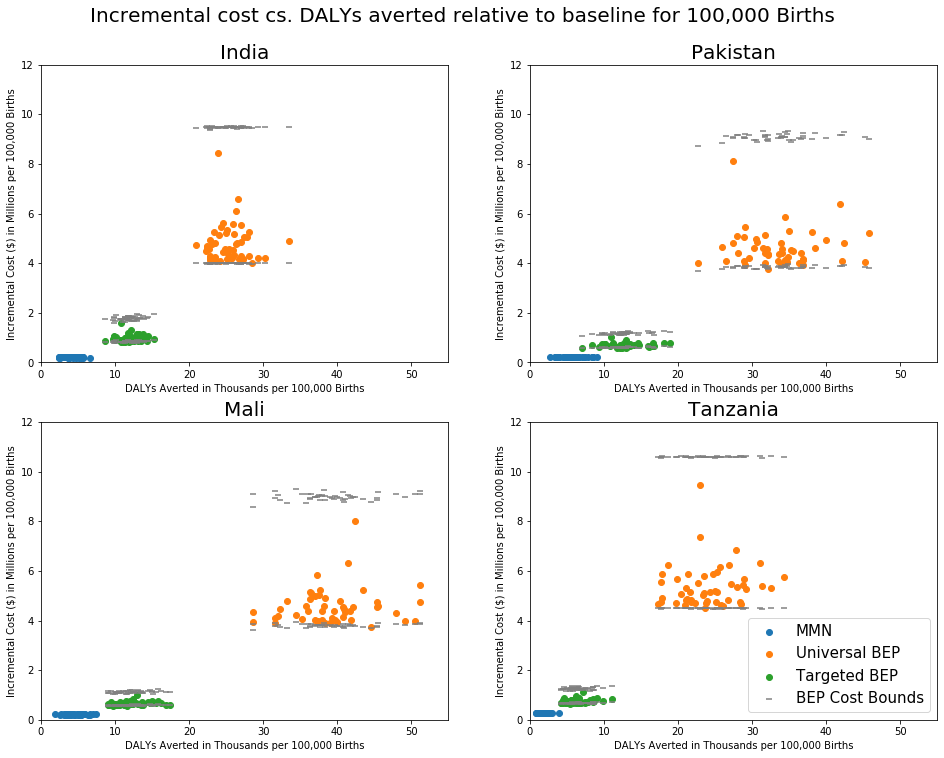

In [8]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()

axs[0,0].scatter(india['dalys_averted_mmn']*(-1)/1_000,india['cost_averted_mmn']/1_000_000)
axs[0,0].scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep']/1_000_000)
axs[0,0].scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted']/1_000_000)
axs[0,0].scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
axs[0,0].scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
axs[0,0].scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
axs[0,0].scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')
axs[0,0].set_title('India',fontsize=20)
axs[0,0].set_xlim(0,55)
axs[0,0].set_ylim(0,12)

axs[0,1].scatter(pakistan['dalys_averted_mmn']*(-1)/1_000,pakistan['cost_averted_mmn']/1_000_000)
axs[0,1].scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep']/1_000_000)
axs[0,1].scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted']/1_000_000)
axs[0,1].scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
axs[0,1].scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
axs[0,1].scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
axs[0,1].scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')
axs[0,1].set_title('Pakistan',fontsize=20)
axs[0,1].set_xlim(0,55)
axs[0,1].set_ylim(0,12)

axs[1,0].scatter(mali['dalys_averted_mmn']*(-1)/1_000,mali['cost_averted_mmn']/1_000_000)
axs[1,0].scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep']/1_000_000)
axs[1,0].scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted']/1_000_000)
axs[1,0].scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
axs[1,0].scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
axs[1,0].scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
axs[1,0].scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')
axs[1,0].set_title('Mali',fontsize=20)
axs[1,0].set_xlim(0,55)
axs[1,0].set_ylim(0,12)

axs[1,1].scatter(tanzania['dalys_averted_mmn']*(-1)/1_000,tanzania['cost_averted_mmn']/1_000_000)
axs[1,1].scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep']/1_000_000)
axs[1,1].scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted']/1_000_000)
axs[1,1].scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
axs[1,1].scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
axs[1,1].scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
axs[1,1].scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')
axs[1,1].set_title('Tanzania',fontsize=20)
axs[1,1].set_xlim(0,55)
axs[1,1].set_ylim(0,12)

for ax in axs.flat:
    ax.set(xlabel='DALYs Averted in Thousands per 100,000 Births', 
           ylabel='Incremental Cost ($) in Millions per 100,000 Births')
    #ax.label_outer()

plt.legend(['MMN','Universal BEP','Targeted BEP','BEP Cost Bounds'], prop={'size': 15})
plt.suptitle('Incremental cost cs. DALYs averted relative to baseline for 100,000 Births',x=1.1,y=2.6,fontsize=20)
plt.subplots_adjust(right=2.2, top=2.4)


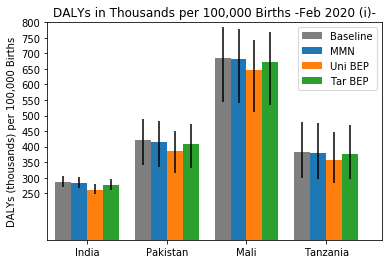

In [14]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()

# bar width
barWidth = 0.2

# bar heights
baseline = master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() / 1_000
baseline_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000
baseline_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000

mmn = master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna()/ 1_000
mmn_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000
mmn_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000

bep = master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna() /1_000
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna())/ 1_000
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep').dropna())/1_000


bep_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna()/1_000
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna())/1_000
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_targeted').dropna())/1_000

# bar positions
baseline_x = np.arange(len(baseline)) 
mmn_x = [x + barWidth for x in baseline_x]
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(baseline_x, baseline, yerr=[baseline_upper, baseline_lower], width=barWidth, color='tab:grey')
plt.bar(mmn_x, mmn, yerr=[mmn_upper, mmn_lower], width=barWidth, color='tab:blue')
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth, color='tab:orange')
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth, color='tab:green')

#
plt.xticks([r + 1.5*barWidth for r in range(len(baseline))], master_avg['location'].where(master_avg['index'] == 'dalys_baseline').dropna())
plt.axis([-0.2 , 4 , 100, 800])
plt.yticks([250,300,350,400,450,500,550,600,650,700,750,800])
plt.ylabel('DALYs (thousands) per 100,000 Births')
plt.title('DALYs in Thousands per 100,000 Births -Feb 2020 (i)-')
plt.legend(['Baseline','MMN','Uni BEP','Tar BEP'], loc=1)
plt.savefig('fig_DALYS')

In [10]:
#INDIA ONLY

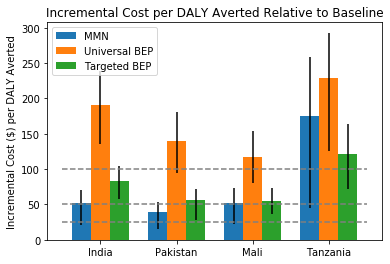

In [11]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)

bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna()*(-1)
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna()*(-1)
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))

#bep_low = master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
#bep_low_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
#bep_low_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)

#bep_targeted_high = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
#bep_targeted_high_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
#bep_targeted_high_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)

# bar positions
mmn_x = np.arange(len(mmn)) 
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(mmn_x, mmn,width=barWidth, yerr=[mmn_upper, mmn_lower])
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)
plt.legend(['MMN','Universal BEP','Targeted BEP','Willingness to Pay Threshold'], loc='upper left')
threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(mmn)-.25], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold3, threshold3],'k--', c='gray')

#
plt.xticks([r + barWidth for r in range(len(mmn))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Baseline')
plt.savefig('fig_ICERS_baseline')

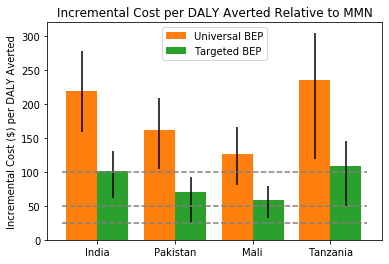

In [12]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.4

# bar heights
bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)
bep_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)
bep_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)
bep_targeted_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)
bep_targeted_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)

# bar positions
bep_x = np.arange(len(bep)) 
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth, color='tab:orange')
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth, color='tab:green')

#
plt.xticks([r + .5*barWidth for r in range(len(bep))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to MMN')
plt.legend(['Universal BEP','Targeted BEP'], loc='upper center')

threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(mmn)-0.33], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(mmn)-0.33], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-0.33], [threshold3, threshold3],'k--', c='gray')
plt.savefig('fig_ICERS_mmn')